# Run remotely

## PythonJob

The `PythonJob` is a built-in task, which uses the [aiida-pythonjob](https://aiida-pythonjob.readthedocs.io/en/latest/) package to run Python functions on a remote computer. It is designed to enable users from non-AiiDA communities to run their Python functions remotely and construct workflows with checkpoints, maintaining all data provenance. For instance, users can use ASE's calculator to run a DFT calculation on a remote computer directly. Users only need to write normal Python code, and the WorkGraph will handle the data transformation to AiiDA data.

### Key Features

1. **Remote Execution**: Seamlessly run Python functions on a remote computer.
2. **User-Friendly**: Designed for users who are not familiar with AiiDA, simplifying the process of remote execution.
3. **Workflow Management**: Construct workflows with checkpoints, ensuring that intermediate states and results are preserved.
4. **Data Provenance**: Maintain comprehensive data provenance, tracking the full history and transformations of data.


Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='91ab760297b7474e99505a4bc4da8805' name='presto'>

## First Workflow
Suppose you need to calculate `(x + y) * z` in two steps: first, add `x` and `y`; second, multiply the result by `z`.

There are three methods to declare a `PythonJob` task in a workflow:

1. **Using the `task.pythonjob` decorator:** Apply this decorator directly when you define the function. This method is straightforward and integrates the task declaration seamlessly with function definition.

2. **Converting an existing function with `task.pythonjob`:** If the function is already defined, you can convert it into a `PythonJob` task by wrapping it with the `task.pythonjob` decorator. This approach is useful when adapting pre-existing code into a task-based workflow.

3. **Specifying `PythonJob` during task addition to the WorkGraph:** When adding a task to the WorkGraph, you can explicitly identify it as a `PythonJob`. This method offers flexibility, allowing you to dynamically assign the task type based on the workflow design requirements.


In [2]:
from aiida_workgraph import WorkGraph, task

# decorator to define a pythonjob
@task.pythonjob()
def add(x, y):
    return x + y


# here is a normal python function
def multiply(x, y):
    return x*y

wg = WorkGraph("first_workflow")
wg.add_task(add, name="add")
# we can also use a normal python function directly, but provide the "PythonJob" as the first argument
wg.add_task("workgraph.pythonjob", function=multiply, name="multiply", x=wg.tasks.add.outputs[0])

# visualize the workgraph
wg.to_html()
# visualize the workgraph in jupyter-notebook
# wg

### Prepare the inputs and submit the workgraph


**Code**: We can set the `computer` to the remote computer where we want to run the job. This will create a code `python3@computer` if it does not already exist. You can also set the `code` directly if you have already created the code.

**Data**: Users are recommended to use normal Python data as input. The workgraph will handle the transfer and serialization of data to AiiDA data. When serializing to AiiDA data, the workgraph will first search for the corresponding AiiDA data entry point based on the module name and class name (e.g., `ase.atoms.Atoms`). If the corresponding entry point exists, it will be used to serialize the value. If not found, `GeneralData` (pickle) will be used to serialize the value into binary data.

**Python Version**: Since pickle is used to store and load data, the Python version on the remote computer should match the one used on the localhost. You can use conda to create a virtual environment with the same Python version. Activate the environment before running the script.

For real applications, you can pass metadata to the scheduler to activate the conda environment:

```python
metadata = {
    "options": {
        'custom_scheduler_commands': 'module load anaconda\nconda activate py3.11\n',
    }
}
```

#### Create a conda environment on the remote computer
One can use the `create_conda_env` function to create a conda environment on the remote computer. The function will create a conda environment with the specified packages and modules. The function will update the packages if the environment already exists.

```python
from aiida_pythonjob.utils import create_conda_env
# create a conda environment on remote computer
create_conda_env("merlin6", "test_pythonjob", modules=["anaconda"],
                 pip=["numpy", "matplotlib"],
                 conda={"channels": ["conda-forge"],
                        "dependencies": ["qe"]},
                )
```

WorkGraph process created, PK: 60947
Process 60947 finished with state: FINISHED

Result of multiply is uuid: 529e4f4a-fff3-4a65-a0b1-8a0f7d2f37c8 (pk: 60963) value: 20 




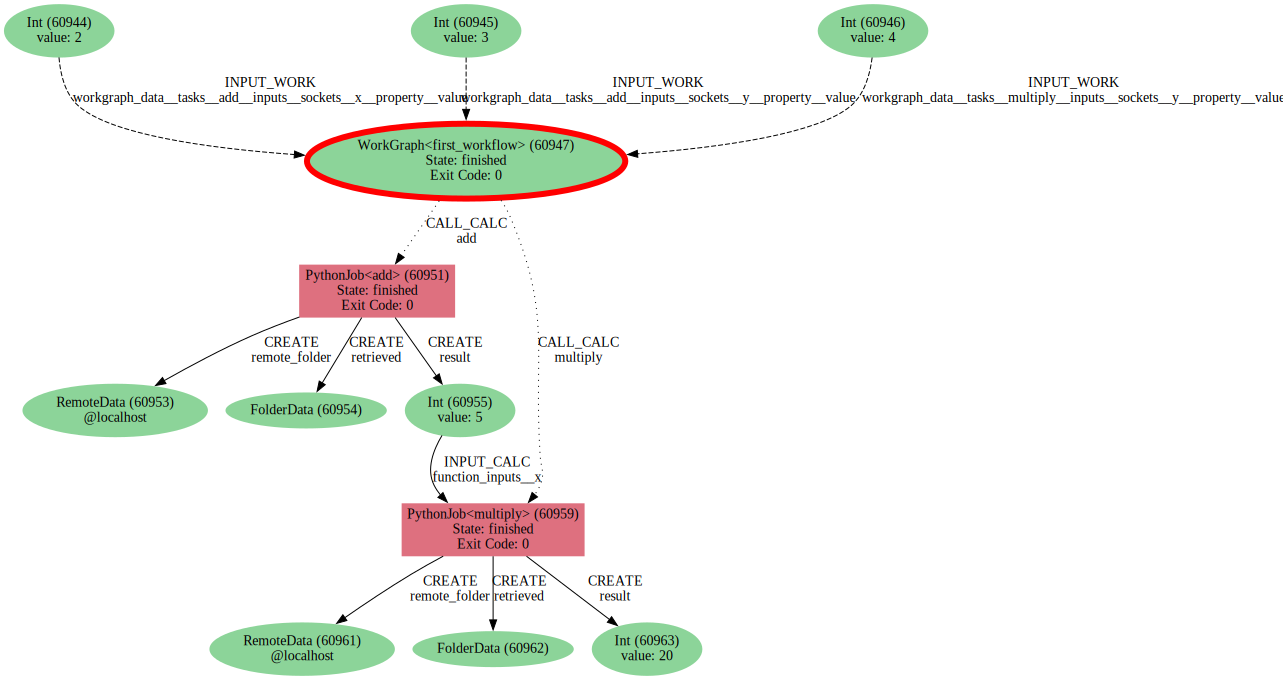

In [3]:
from aiida_workgraph.utils import generate_node_graph

#------------------------- Submit the calculation -------------------
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        # 'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
        'custom_scheduler_commands' : '',
    }
}

wg.submit(inputs = {"add": {"x": 2, "y": 3,
                            "computer": "localhost",
                            "metadata": metadata},
                    "multiply": {"y": 4,
                                 "computer": "localhost",
                                 "metadata": metadata}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.tasks.multiply.outputs.result.value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## Use parent folder
The parent_folder parameter allows a task to access the output files of a parent task. This feature is particularly useful when you want to reuse data generated by a previous computation in subsequent computations. In the following example, the multiply task uses the `result.txt` file created by the add task.


In [4]:
from aiida_workgraph import WorkGraph, task

@task.pythonjob()
def add(x, y):
    z = x + y
    with open("result.txt", "w") as f:
        f.write(str(z))

@task.pythonjob()
def multiply(x, y):
    with open("parent_folder/result.txt", "r") as f:
        z = int(f.read())
    return x*y + z

wg = WorkGraph("PythonJob_parent_folder")
wg.add_task(add, name="add")
wg.add_task(multiply, name="multiply",
             parent_folder=wg.tasks.add.outputs.remote_folder,
             )

wg.to_html()

Submit the workgraph and print the result.

In [5]:
wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"x": 3, "y": 4, "computer": "localhost"}},
          wait=True)
print("\nResult of multiply is {} \n\n".format(wg.tasks.multiply.outputs.result.value))

WorkGraph process created, PK: 60968
Process 60968 finished with state: FINISHED

Result of multiply is uuid: 763a0770-a9fe-4b24-9251-ac9317991e74 (pk: 60984) value: 17 




## Upload files or folders to the remote computer
The `upload_files` parameter allows users to upload files or folders to the remote computer. The files will be uploaded to the working directory of the remote computer.



In [6]:
from aiida_workgraph import WorkGraph, task

# create a temporary file "input.txt" in the current directory
with open("input.txt", "w") as f:
    f.write("2")

# create a temporary folder "inputs_folder" in the current directory
# and add a file "another_input.txt" in the folder
import os
os.makedirs("inputs_folder", exist_ok=True)
with open("inputs_folder/another_input.txt", "w") as f:
    f.write("3")

@task.pythonjob()
def add():
    with open("input.txt", "r") as f:
        a = int(f.read())
    with open("inputs_folder/another_input.txt", "r") as f:
        b = int(f.read())
    return a + b


wg = WorkGraph("PythonJob_upload_files")
wg.add_task(add, name="add")

#------------------------- Submit the calculation -------------------
# we need use full path to the file
input_file = os.path.abspath("input.txt")
input_folder = os.path.abspath("inputs_folder")

wg.submit(inputs = {"add": {
                            "computer": "localhost",
                            "upload_files": {"input_file": input_file,
                                             "inputs_folder": input_folder,
                                             },
                            },
                    },
          wait=True)
print("\nResult of add is {} \n\n".format(wg.tasks.add.outputs['result'].value))

WorkGraph process created, PK: 60985
Process 60985 finished with state: FINISHED

Result of add is uuid: 5df2bdbb-e5bf-4d16-bc4f-357f41233e9f (pk: 60995) value: 5 




## ShellJob

TODO

## CalcJob

TODO